In [1]:
%ls data

archive.zip                            olist_orders_dataset.csv
olist_customers_dataset.csv            olist_products_dataset.csv
olist_geolocation_dataset.csv          olist_products_dataset_po.csv
olist_order_items_dataset.csv          olist_sellers_dataset.csv
olist_order_payments_dataset.csv       product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [125]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
import opendatasets as od
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from collections import Counter
from PIL import Image


# # Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# import tensorflow_hub as hub
# from object_detection.utils import visualization_utils as viz_utils

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [3]:
geo_data = pd.read_csv('data/olist_geolocation_dataset.csv')
order_data = pd.read_csv('data/olist_orders_dataset.csv')
order_item_data = pd.read_csv('data/olist_order_items_dataset.csv')
products_data = pd.read_csv('data/olist_products_dataset.csv')
sellers_data = pd.read_csv('data/olist_sellers_dataset.csv')
payment_data = pd.read_csv('data/olist_order_payments_dataset.csv')

## diff_days

### 결측값 채우기

In [4]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**결측값의 비율은 약 3%이므로 'order_delivered_customer_date'의 Null 값은 'order_estimated_delivery_date'로 채우기**

In [5]:
## **결측값의 비율은 약 3%이므로 고객 날짜 기능의 Null 값은 forward-fill method로 채우기**
# order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
# order_data['order_delivered_customer_date'].isnull().sum()

In [6]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(order_data['order_estimated_delivery_date'])
order_data['order_delivered_customer_date'].isnull().sum()

0

### 날짜 컬럼 생성

**배송 완료 날짜 및 예상 날짜 컬럼 생성**

In [7]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

**주문 배송된 고객 날짜를 기준으로 Weekly 생성**

In [8]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

<ipython-input-8-7141a3e5f4d0>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],


**주문 배송된 고객 날짜를 기반으로 Monthly 생성**

In [9]:
order_data['monthly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['monthly']= order_data['monthly'].astype(str)

### diff_days 생성

**예상 날짜와 배송된 날짜의 차이로 diff_days 생성**

In [10]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

In [11]:
# 배송완료된 주문제품만
order_data_delivery = order_data[order_data["order_status"]=='delivered']

In [12]:
# 배송완료 예정 날짜보다 늦게 배송된 경우
order_data_delivery[order_data_delivery['diff_days']>0].shape

(6534, 13)

In [13]:
# 배송완료 예정 날짜 = 실제 배송완료 날짜
order_data_delivery[order_data_delivery['diff_days']==0].shape

(1300, 13)

In [14]:
# 배송완료 예정 날짜보다 빨리 배송된 경우
order_data_delivery[order_data_delivery['diff_days']<0].shape

(88644, 13)

In [15]:
order_data_delivery.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,weekly,monthly,diff_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-10,2017-10-18,41,2017-10,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-08-07,2018-08-13,32,2018-08,-6


### weekly diff_days

In [16]:
order_data_delivery.groupby(['weekly'])["diff_days"].mean()

weekly
1     -9.179291
2    -11.274967
3    -13.562369
4    -14.163656
5    -15.182986
6    -16.203322
7    -15.799630
8    -13.617605
9    -11.401540
10   -10.357715
11    -9.141724
12    -8.606580
13    -9.058068
14    -7.699257
15    -8.748567
16    -9.904279
17   -11.989136
18   -11.790677
19   -11.844112
20   -11.816672
21   -11.213804
22   -11.815772
23   -13.277978
24   -18.280579
25   -16.657393
26   -16.180823
27   -15.812530
28   -14.131258
29   -12.202691
30   -11.657437
31   -11.331565
32    -9.960604
33    -8.816615
34   -10.163465
35   -10.815978
36   -11.667949
37   -10.772212
38    -5.782814
39   -11.297828
40   -13.302050
41   -15.554979
42   -13.951473
43   -13.352159
44   -12.252772
45   -11.619243
46   -10.698646
47   -10.564319
48   -10.555990
49   -11.439655
50   -11.378305
51   -10.894824
52   -11.250749
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Week')

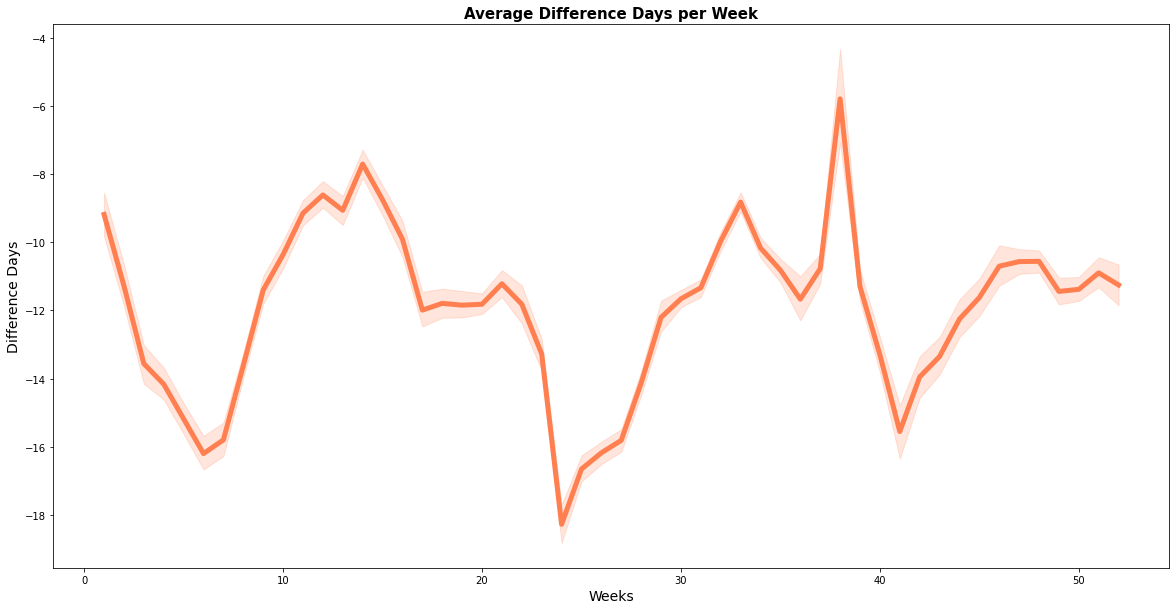

In [17]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data_delivery, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

### monthly diff_days

In [18]:
order_data_delivery.groupby(['monthly'])["diff_days"].mean()

monthly
2016-10   -41.434146
2016-11   -20.379310
2016-12    -7.250000
2017-01   -30.056537
2017-02   -25.159141
2017-03   -14.372796
2017-04   -14.546241
2017-05   -12.490269
2017-06   -13.530397
2017-07   -12.523300
2017-08   -13.255463
2017-09   -10.343001
2017-10   -12.648865
2017-11   -10.765310
2017-12   -11.242992
2018-01   -11.997878
2018-02   -12.132479
2018-03    -7.889215
2018-04    -8.353758
2018-05   -11.275489
2018-06   -16.790630
2018-07   -13.676762
2018-08    -8.372865
2018-09    22.553571
2018-10    83.666667
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Month')

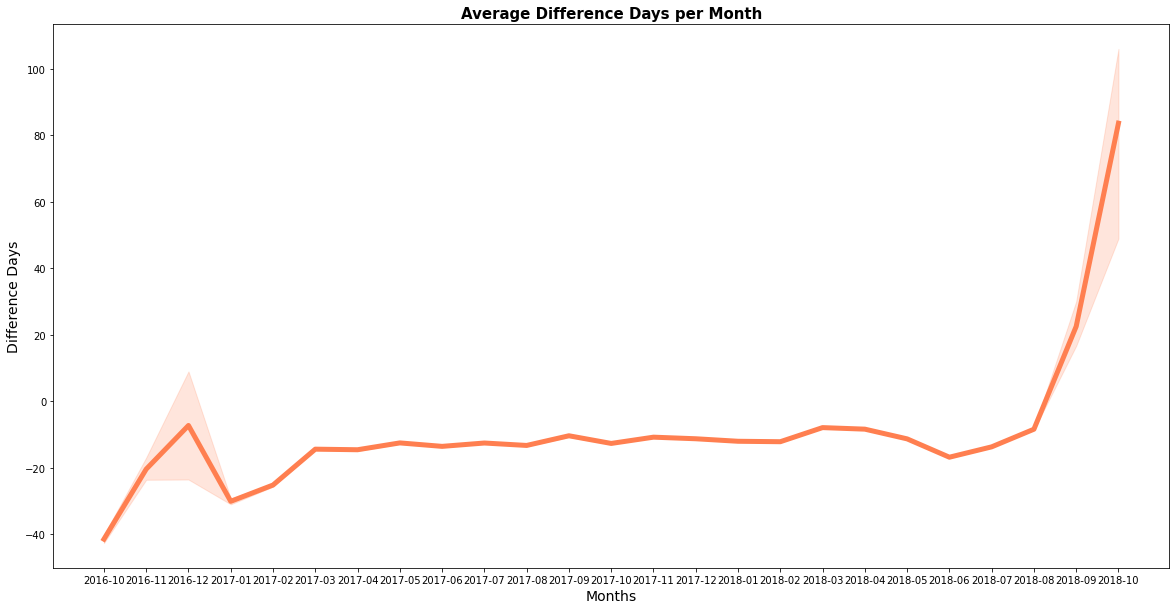

In [19]:
order_data_delivery1 = order_data_delivery
order_data_delivery1 = order_data_delivery.sort_values('monthly')

plt.figure(figsize=(20,10))
sns.lineplot(x='monthly', y='diff_days', data=order_data_delivery1, color="coral", linewidth=5,
            markers=True,dashes=False,estimator='mean')

plt.xlabel("Months", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Month",size=15, weight='bold')

### seller/category 별 diff_days

**배송예상날짜와 배송완료날짜 차이를 판매자와 카테고리별로 보기 위해**

In [20]:
df_orders = pd.merge(order_data, order_item_data, on="order_id",how = 'right')

In [21]:
df_orders = pd.merge(df_orders, products_data, on="product_id",how = 'right')

In [22]:
df_orders = df_orders.drop_duplicates(['order_id','product_id'], keep = 'first')

In [23]:
df_orders[df_orders.duplicated(['order_id','product_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,...,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [24]:
# 배송완료된 주문 제품만
df_orders_delivery = df_orders[df_orders["order_status"]=='delivered']

#### seller > diff_days

**seller별 배송예상날짜와 실제배송날짜 차이 평균**

In [25]:
df_orders_delivery.groupby(['seller_id'])["diff_days"].mean().sort_values()

seller_id
933446e9a59dece7ae9175103820ca8f    -66.0
0b09101900100c0e9d312861fad5a1b9    -61.0
fa5fdc4e4bb6bd1009ad0e4ac4096562    -58.0
ffff564a4f9085cd26170f4732393726    -48.0
58e4b302b54937e55a678c4d15111da4    -48.0
                                    ...  
6f1a1263039c76e68f40a8e536b1da6a     31.0
8629a7efec1aab257e58cda559f03ba7     33.0
4fb41dff7c50136976d1a5cf004a42e2     33.0
8e670472e453ba34a379331513d6aab1     35.0
df683dfda87bf71ac3fc63063fba369d    167.0
Name: diff_days, Length: 2970, dtype: float64

#### category > diff_days

**카테고리별 배송예상날짜와 실제배송날짜 차이 평균**

In [26]:
df_orders.groupby(['product_category_name'])["diff_days"].mean().sort_values()

product_category_name
security_and_services               -17.000000
la_cuisine                          -16.384615
cds_dvds_musicals                   -15.833333
fixed_telephony                     -14.562212
fashion_shoes                       -14.521236
                                       ...    
home_confort                         -9.679803
food                                 -9.626932
home_comfort_2                       -8.708333
furniture_mattress_and_upholstery    -6.973684
arts_and_craftmanship                -6.791667
Name: diff_days, Length: 71, dtype: float64

In [27]:
df_orders_delivery['diff_days'].sort_values()

84882    -147
103127   -140
20985    -135
87161    -124
59215    -109
         ... 
36542     166
95255     167
110636    175
1466      181
86906     188
Name: diff_days, Length: 100196, dtype: int64

Text(0.5, 1.0, 'Average Difference Days per Category')

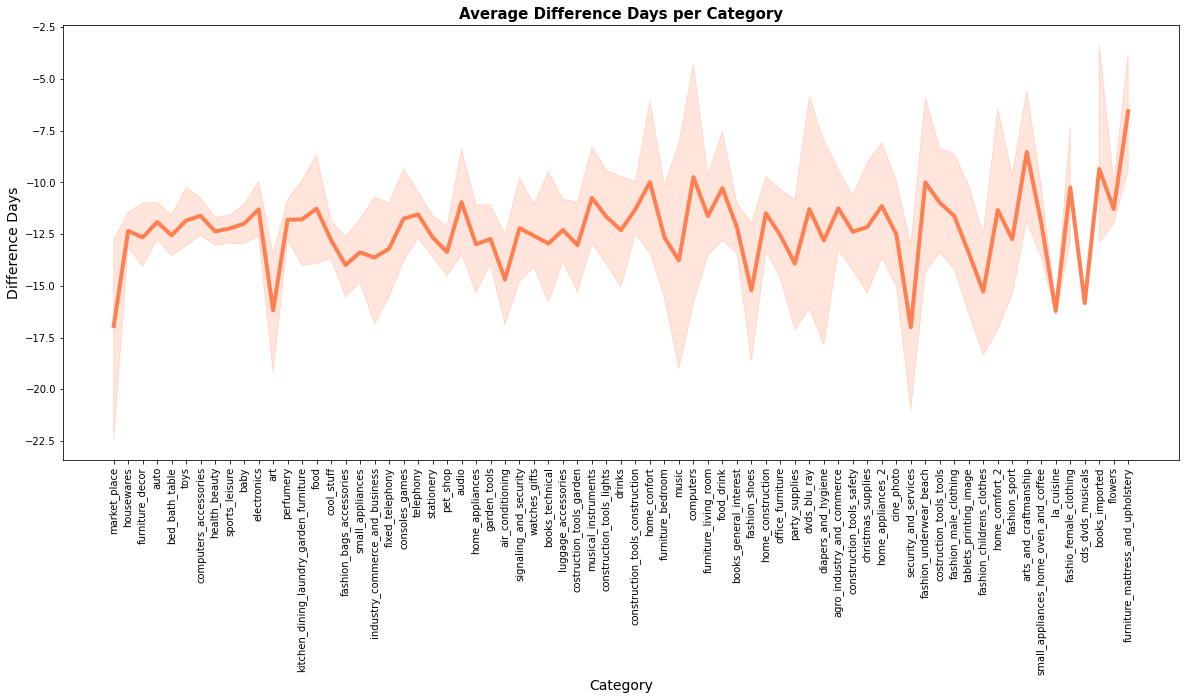

In [30]:
df_agg1 = df_agg
df_agg1 = df_agg.sort_values('diff_days')

plt.figure(figsize=(20,8))
sns.lineplot(x='product_category_name', y='diff_days', data=df_agg1, color="coral", linewidth=4,
            markers=True,dashes=False,estimator='mean')
plt.xticks(rotation=90)
plt.xlabel("Category", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Category",size=15, weight='bold')

#### category > seller > diff_days

**카테고리별 셀러의 배송예상날짜와 실제배송날짜 차이 평균 순위**

In [29]:
# 첫 번째 그룹바이
df_agg = df_orders_delivery.groupby(['product_category_name','seller_id']).agg({'diff_days':'mean'})
df_agg

diff_days
product_category_name      seller_id                                  
agro_industry_and_commerce 06579cb253ecd5a3a12a9e6eb6bf8f47 -10.000000
                           0ed6ce5d87fd9c69eaacaeb778d67235  -9.000000
                           2528744c5ef5d955adc318720a94d2e7  -9.400000
                           269cff2d3c8d205c11f37a52402ea93b  -9.000000
                           31ae0774c17fabd06ff707cc5bde005f -12.857143
...                                                                ...
watches_gifts              f8db351d8c4c4c22c6835c19a46f01b0 -11.200000
                           f9eedec3129e8cc6b6429c42d0808c5b  -9.000000
                           fa1c13f2614d7b5c4749cbc52fecda94 -10.309441
                           fcba71d4d5db057f43249145e4eb1e27  -7.666667
                           ffc470761de7d0232558ba5e786e57b7 -13.400000

[6144 rows x 1 columns]

In [31]:
# 인덱스의 첫 번째 수준으로 그룹화
g = df_agg['diff_days'].groupby(level=0, group_keys=False)

In [32]:
# 각 그룹 내에서 diff_days 열을 내림차순으로 정렬하고 상위 3 개 행만 가져오기
#delivery_ = g.apply(lambda x: x.order(ascending=False).head(3))
delivery_fast = g.apply(lambda x: x.sort_values(ascending=False).tail(3))
delivery_fast

product_category_name       seller_id                       
agro_industry_and_commerce  6b2612338467c08c9b25f0cc55b1578d   -22.000000
                            85cc55e048b6bcc90c75afe7f0e72f72   -23.000000
                            55bb6fe5bebe5012e2d7d9928e1128ff   -24.000000
air_conditioning            ac6417315ae5da8f9a38ee11de6f7780   -28.000000
                            c7dcd301ecfe5ab7f778ac172cf74be7   -29.000000
                                                                  ...    
toys                        e883aa812c37a7413226856f4579fe91   -37.000000
                            4bde6149c15cf7e177b36fa060dd6de8   -52.000000
watches_gifts               710e3548e02bc1d2831dfc4f1b5b14d4   -29.666667
                            747e73c01a4593d4cf60dcf970fd2689   -30.000000
                            9f505651f4a6abe901a56cdc21508025   -33.333333
Name: diff_days, Length: 209, dtype: float64

In [33]:
delivery_slow = g.apply(lambda x: x.sort_values(ascending=False).head(3))
delivery_slow

product_category_name       seller_id                       
agro_industry_and_commerce  3d0cd21d41671c46f82cd11176bf7277    -2.000000
                            397c4d0c005b6f41f90098ac724e28cb    -3.000000
                            6bd69102ab48df500790a8cecfc285c2    -3.600000
air_conditioning            15aac934c58d886785ac1b17953ea898     4.666667
                            b2ba3715d723d245138f291a6fe42594    -2.000000
                                                                  ...    
toys                        4c8b8048e33af2bf94f2eb547746a916    12.000000
                            bdb3edbaee43a761e2d4f258dc08f348     7.000000
watches_gifts               4fb41dff7c50136976d1a5cf004a42e2    33.000000
                            e7df4cd29ab5abab70fb0783ddb53987     6.000000
                            e82de6494d91d3c4c54450f59b227a94     3.000000
Name: diff_days, Length: 209, dtype: float64

In [34]:
# 한번에 보기
df_orders_delivery.groupby(['product_category_name']).apply(lambda x: (x.groupby('seller_id')
                                      .mean()
                                      .sort_values('diff_days', ascending=False))
                                     .tail(3))

weekly  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   9.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72  31.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff  22.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  19.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  43.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91  34.000000   
                           4bde6149c15cf7e177b36fa060dd6de8  41.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  34.000000   
                           747e73c01a4593d4cf60dcf970fd2689  14.333333   
                           9f505651f4a6abe901a56cdc21508025  21.666667   

                                                             diff_days  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d -22.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72 -23.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff -24.000000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780 -28.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7 -29.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91 -37.000000   
                           4bde6149c15cf7e177b36fa060dd6de8 -52.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4 -29.666667   
                           747e73c01a4593d4cf60dcf970fd2689 -30.000000   
                           9f505651f4a6abe901a56cdc21508025 -33.333333   

                                                             order_item_id  \
product_category_name      seller_id                                         
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d            1.0   
                           85cc55e048b6bcc90c75afe7f0e72f72            1.0   
                           55bb6fe5bebe5012e2d7d9928e1128ff            1.0   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780            1.0   
                           c7dcd301ecfe5ab7f778ac172cf74be7            1.0   
...                                                                    ...   
toys                       e883aa812c37a7413226856f4579fe91            1.0   
                           4bde6149c15cf7e177b36fa060dd6de8            1.0   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4            1.0   
                           747e73c01a4593d4cf60dcf970fd2689            1.0   
                           9f505651f4a6abe901a56cdc21508025            1.0   

                                                                  price  \
product_category_name      seller_id                                      
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   92.900000   
                           85cc55e048b6bcc90c75afe7f0e72f72   33.900000   
                           55bb6fe5bebe5012e2d7d9928e1128ff   98.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  110.300000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  299.990000   
...                                                                 ...   
toys                       e883aa812c37a7413226856f4579fe91   59.900000   
                           4bde6149c15cf7e177b36fa060dd6de8   79.900000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  149.990000   
                           747e73c01a4593d4cf60dcf970fd2689  739.330000   
                           9f505651f4a6abe901a56cdc21508025   21.656667   

                                                             freight_value  \
product_category_name      seller_id                                 

#### 카테고리 종류 보기

In [35]:
# 카테고리 종류 보기
df_orders_delivery['product_category_name'].unique().tolist()

['perfumery',
 'art',
 'sports_leisure',
 'baby',
 'housewares',
 'musical_instruments',
 'cool_stuff',
 'furniture_decor',
 'home_appliances',
 'toys',
 'bed_bath_table',
 'construction_tools_safety',
 'computers_accessories',
 'health_beauty',
 'luggage_accessories',
 'garden_tools',
 'office_furniture',
 'auto',
 'electronics',
 'fashion_shoes',
 'telephony',
 'stationery',
 'fashion_bags_accessories',
 'computers',
 'home_construction',
 'watches_gifts',
 'construction_tools_construction',
 'pet_shop',
 'small_appliances',
 'agro_industry_and_commerce',
 nan,
 'furniture_living_room',
 'signaling_and_security',
 'air_conditioning',
 'consoles_games',
 'books_general_interest',
 'costruction_tools_tools',
 'fashion_underwear_beach',
 'fashion_male_clothing',
 'kitchen_dining_laundry_garden_furniture',
 'industry_commerce_and_business',
 'fixed_telephony',
 'construction_tools_lights',
 'books_technical',
 'home_appliances_2',
 'party_supplies',
 'drinks',
 'market_place',
 'la_cuisi

In [121]:
df_orders_delivery['product_category_name_port'].unique().tolist()

['perfumaria',
 'artes',
 'esporte_lazer',
 'bebes',
 'utilidades_domesticas',
 'instrumentos_musicais',
 'cool_stuff',
 'moveis_decoracao',
 'eletrodomesticos',
 'brinquedos',
 'cama_mesa_banho',
 'construcao_ferramentas_seguranca',
 'informatica_acessorios',
 'beleza_saude',
 'malas_acessorios',
 'ferramentas_jardim',
 'moveis_escritorio',
 'automotivo',
 'eletronicos',
 'fashion_calcados',
 'telefonia',
 'papelaria',
 'fashion_bolsas_e_acessorios',
 'pcs',
 'casa_construcao',
 'relogios_presentes',
 'construcao_ferramentas_construcao',
 'pet_shop',
 'eletroportateis',
 'agro_industria_e_comercio',
 nan,
 'moveis_sala',
 'sinalizacao_e_seguranca',
 'climatizacao',
 'consoles_games',
 'livros_interesse_geral',
 'construcao_ferramentas_ferramentas',
 'fashion_underwear_e_moda_praia',
 'fashion_roupa_masculina',
 'moveis_cozinha_area_de_servico_jantar_e_jardim',
 'industria_comercio_e_negocios',
 'telefonia_fixa',
 'construcao_ferramentas_iluminacao',
 'livros_tecnicos',
 'eletrodomesti

## Top 10

In [45]:
#Merge data
total_orders=pd.merge(order_data, order_item_data)
product_orders=pd.merge(total_orders,products_data, on="product_id")
product_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  monthly                        112650 non-null  object 
 12  diff_days                     

### Top 10 Product

**product_id 값 이름 줄이기**
- 마지막 8자만 가져오기 (고유성이 유지되는지 확인)

In [46]:
len(product_orders['product_id'].unique())

32951

In [47]:
len(product_orders['product_id'].str[-8:].unique())

32951

In [48]:
product_orders['product_id_shorten']=product_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

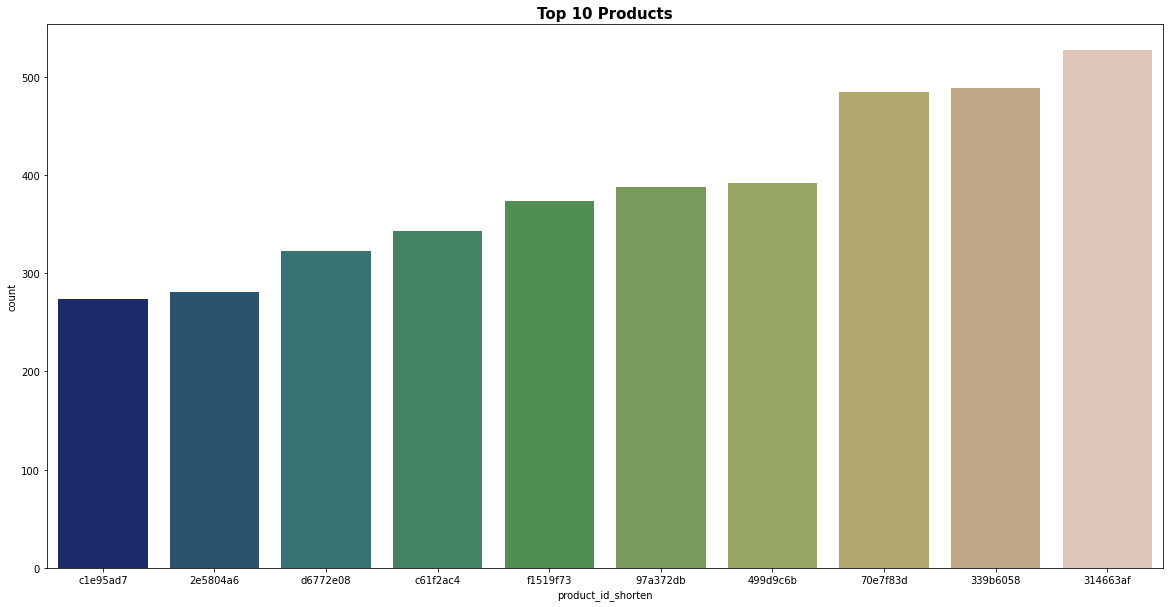

In [49]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=product_orders, palette='gist_earth',
             order=product_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

**Top 10 Product의 카테고리**

In [50]:
group_category= product_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name
314663af            furniture_decor          527
339b6058            bed_bath_table           488
70e7f83d            garden_tools             484
499d9c6b            garden_tools             392
97a372db            garden_tools             388
f1519f73            garden_tools             373
c61f2ac4            computers_accessories    343
d6772e08            watches_gifts            323
2e5804a6            health_beauty            281
c1e95ad7            computers_accessories    274
Name: product_id_shorten, dtype: int64

### Top 10 Category

In [51]:
product_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
bed_bath_table           11115
health_beauty             9670
sports_leisure            8641
furniture_decor           8334
computers_accessories     7827
housewares                6964
watches_gifts             5991
telephony                 4545
garden_tools              4347
auto                      4235
Name: product_id_shorten, dtype: int64

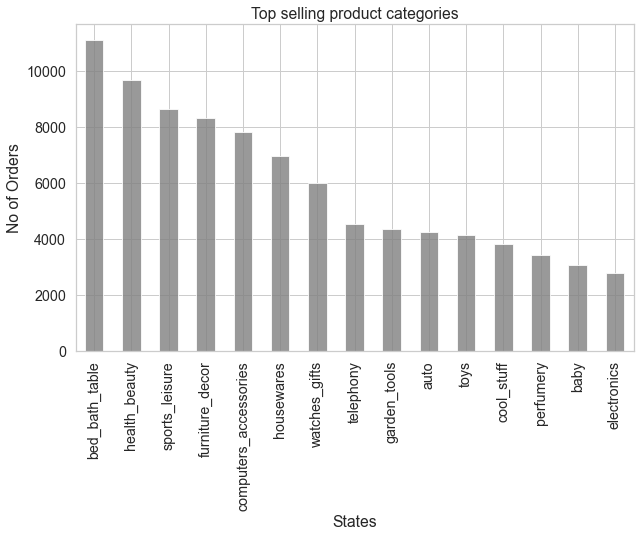

In [183]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = product_orders.product_category_name.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("States")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

### Top 10 Seller

In [52]:
#First seller dataset will be merged with the product orders data.
seller_products = pd.merge(product_orders, sellers_data, on="seller_id")
seller_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  monthly                        112650 non-null  object 
 12  diff_days                     

**seller id 길이 줄이기**
- 마지막 6자만 가져오기 (고유성이 유지되는지 확인)

In [54]:
len(seller_products['seller_id'].unique())

3095

In [55]:
len(seller_products['seller_id'].str[-6:].unique())

3095

In [56]:
seller_products['seller_id_shorten']=seller_products['seller_id'].str[-6:]

In [79]:
seller_products.groupby(['seller_id_shorten'])['seller_id_shorten'].count().sort_values(ascending=False).head(10)

seller_id_shorten
7e94c0    2033
493884    1987
523100    1931
b7556a    1775
dab84a    1551
80ce60    1499
0e0bfa    1428
b010ab    1364
f13abc    1203
3ad736    1171
Name: seller_id_shorten, dtype: int64

**Top 10 Seller**
- 상위 3명의 판매자는 비율이 비슷

Text(0.5, 1.0, 'Top 10 Seller')

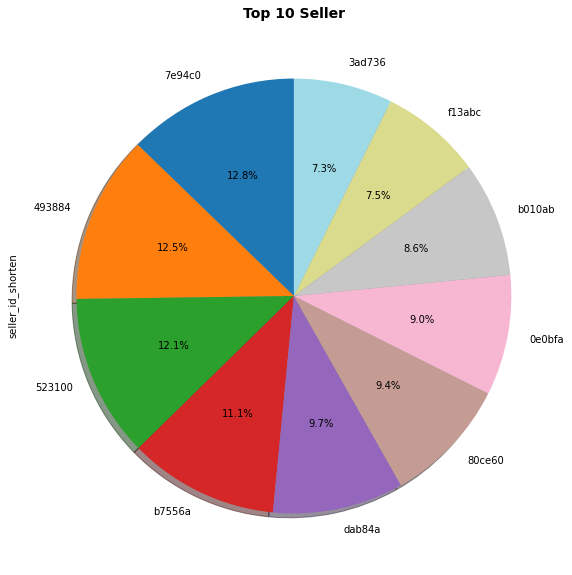

In [58]:
plt.figure(figsize=(20,10))
seller_products['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')

### seller > category Top 10

In [59]:
seller_category= seller_products.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

seller_id_shorten  product_category_name
523100             garden_tools             1882
7e94c0             watches_gifts            1628
493884             bed_bath_table           1572
0e0bfa             furniture_decor          1292
dab84a             bed_bath_table           1277
b010ab             office_furniture         1233
f13abc             telephony                1178
b7556a             health_beauty            1091
3ad736             cool_stuff               1069
3b52b2             watches_gifts            1002
Name: seller_id_shorten, dtype: int64

In [80]:
# seller_products.groupby(['seller_id_shorten']).apply(lambda x: (x.groupby('product_category_name')
#                                       .count()
#                                       .sort_values('seller_id_shorten', ascending=False))
#                                      .head(3))

### top10 Products  &  top10 Sellers > Category

- 가장 많이 판매되는 제품의 카테고리는 홈 데코레이션 이지만 top seller의 가장 많이 판매되는 카테고리는 정원 도구

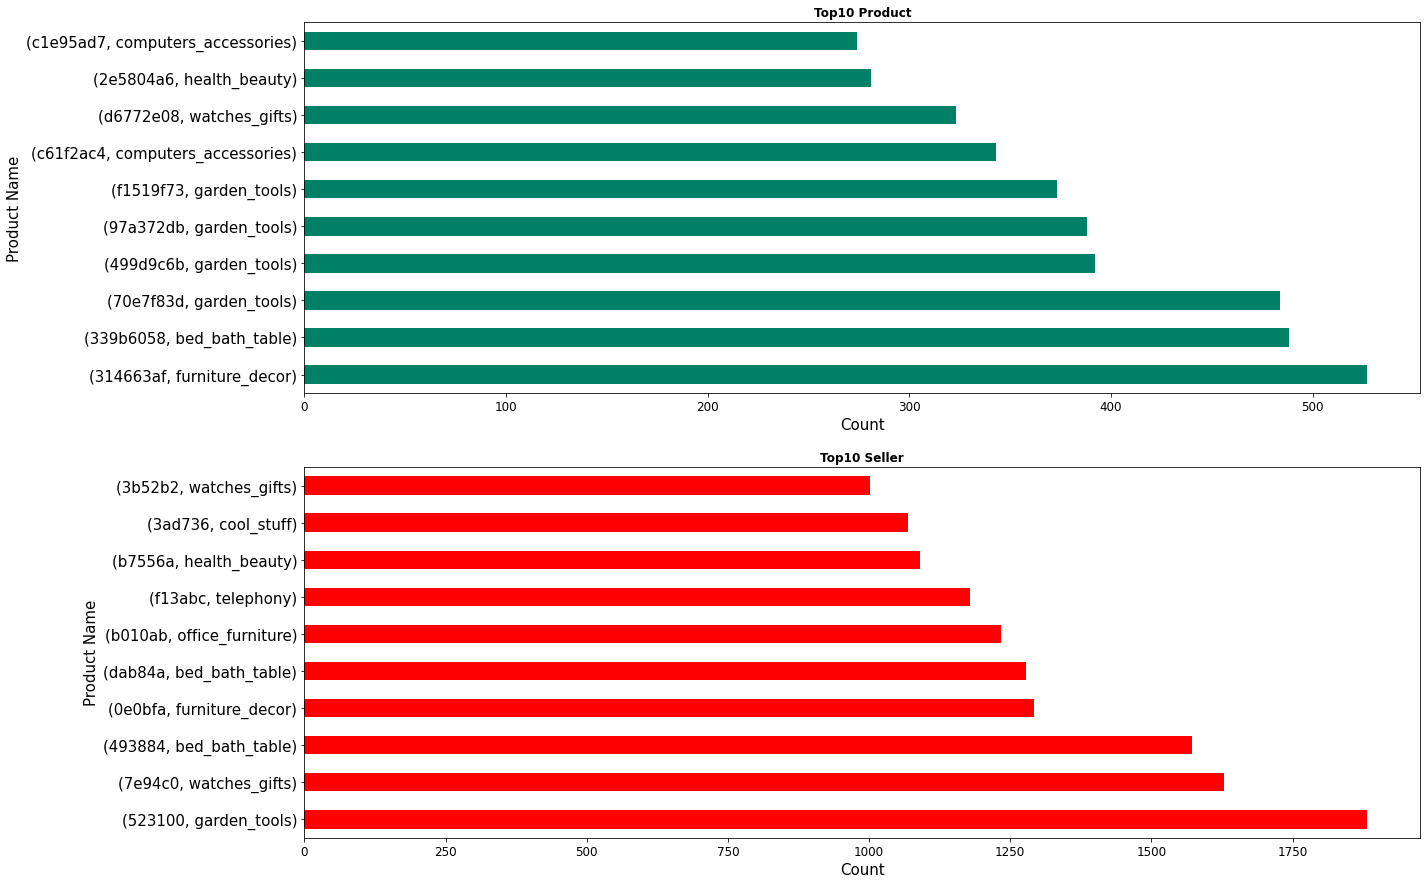

In [81]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)

#### 가장 많이 팔린 제품 314663af(홈 데코레이션 카테고리의 제품)의 주간 구매 수량

In [83]:
# First creating new feature of weeks
product_orders['order_week']= pd.to_datetime(product_orders['order_purchase_timestamp'],
                                            format='%Y-%m-%d').dt.isocalendar().week

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Weekly Purchased Number of `314663af`')

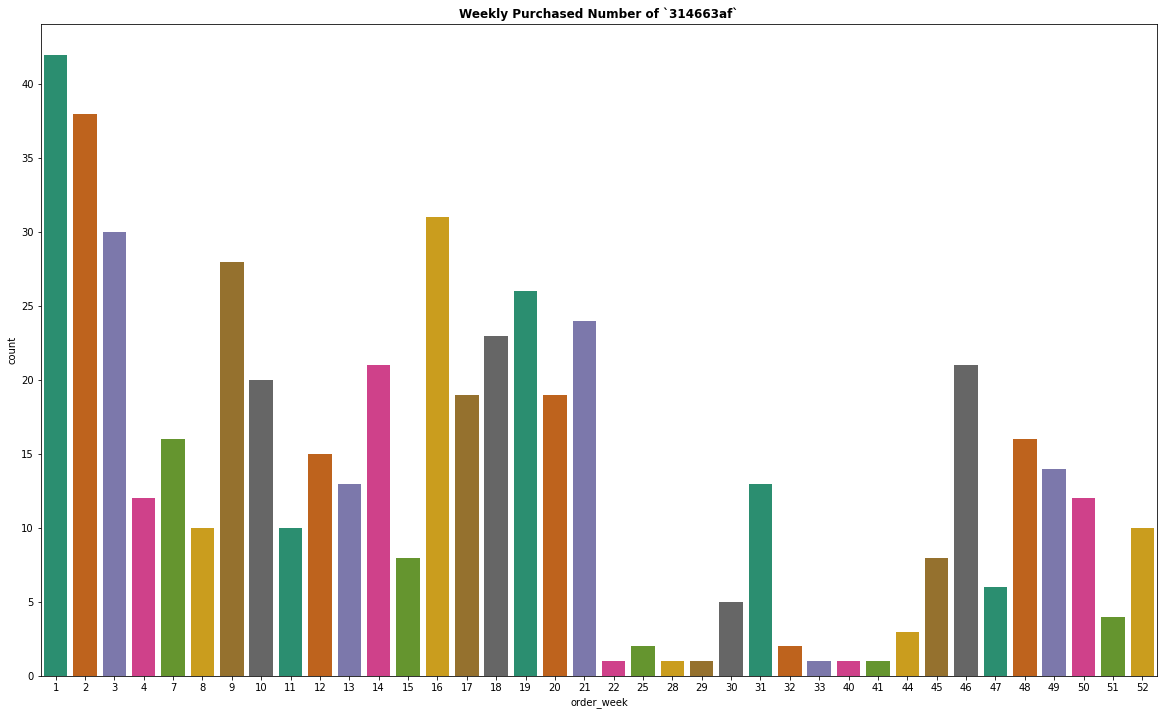

In [84]:
plt.figure(figsize=(20,12))
sns.countplot('order_week', data=product_orders[product_orders['product_id_shorten']== 
                                        '314663af'], palette='Dark2', linewidth=5)\
                                        .set_title('Weekly Purchased Number of `314663af`'
                                                   ,fontweight='bold')

- 314663af의 주간 구매 수량
- 가장 적게 구매한 달은 6월과 8월

#### 가장 많이 팔린 제품 314663af(홈 데코레이션 카테고리의 제품)의 월간 구매 수량

In [85]:
product_orders['order_month']=pd.to_datetime(product_orders['order_purchase_timestamp'])\
                    .dt.to_period('M')
product_orders['order_month']= product_orders['order_month'].astype(str)

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Monthly Purchased Number of `314663af`')

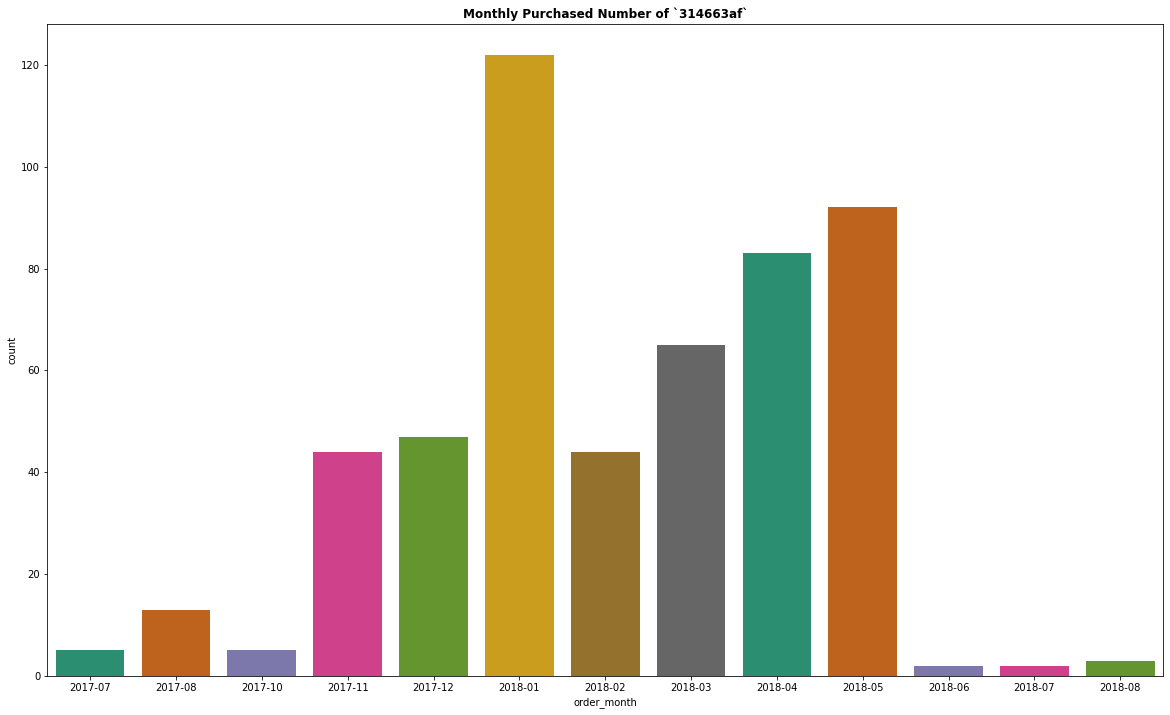

In [86]:
product_orders = product_orders.sort_values('order_month')

plt.figure(figsize=(20,12))
sns.countplot('order_month', data=product_orders[product_orders['product_id_shorten']== 
                                        '314663af'], palette='Dark2', linewidth=5)\
                                        .set_title('Monthly Purchased Number of `314663af`'
                                                   ,fontweight='bold')

#### 주 단위로 가장 많이 팔린 상품 카테고리

In [87]:
#Weekly popular items 
items_weekly =product_orders.groupby(['order_week','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_weekly.reset_index(name='count')

In [88]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_week'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_week,product_category_name,count
0,47,bed_bath_table,438
2,33,bed_bath_table,355
3,29,bed_bath_table,339
4,32,health_beauty,330
5,8,computers_accessories,330
8,31,health_beauty,320
9,9,computers_accessories,314
10,19,health_beauty,310
11,18,health_beauty,302
12,23,bed_bath_table,301


In [89]:
max_selling_products['product_category_name'].value_counts()

bed_bath_table           33
health_beauty            10
computers_accessories     3
sports_leisure            3
furniture_decor           2
toys                      1
Name: product_category_name, dtype: int64

- 52주 중 33주 동안 가장 많이 팔린 상품이 bed_table_bath
- 이 카테고리는 가장 많이 판매되는 제품 그룹 또는 가장 많이 판매되는 그룹의 상위 3개에 속함

#### 월 단위로 가장 많이 팔린 상품 카테고리

In [90]:
#Monthly popular items 
items_monthly =product_orders.groupby(['order_month','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_monthly.reset_index(name='count')

In [91]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_month'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_month,product_category_name,count
0,2018-02,computers_accessories,981
1,2017-11,bed_bath_table,975
2,2018-06,health_beauty,885
3,2018-08,health_beauty,849
4,2018-01,bed_bath_table,848
5,2018-03,bed_bath_table,798
6,2018-07,health_beauty,784
9,2018-05,health_beauty,770
13,2018-04,bed_bath_table,746
35,2017-07,bed_bath_table,579


In [92]:
max_selling_products['product_category_name'].value_counts()

bed_bath_table                             12
health_beauty                               5
furniture_decor                             4
computers_accessories                       1
fashion_bags_accessories                    1
kitchen_dining_laundry_garden_furniture     1
Name: product_category_name, dtype: int64

## Price

지불 금액(payment value)과 총 주문 금액(total order value)으로 총 이익(Gross Profit)과 이익 마진(Profit Margin)을 계산 가능

In [93]:
payments=pd.merge(seller_products, payment_data, on="order_id")
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   customer_id                    117601 non-null  object 
 2   order_status                   117601 non-null  object 
 3   order_purchase_timestamp       117601 non-null  object 
 4   order_approved_at              117586 non-null  object 
 5   order_delivered_carrier_date   116356 non-null  object 
 6   order_delivered_customer_date  117601 non-null  object 
 7   order_estimated_delivery_date  117601 non-null  object 
 8   delivered_time                 117601 non-null  object 
 9   estimate_time                  117601 non-null  object 
 10  weekly                         117601 non-null  int64  
 11  monthly                        117601 non-null  object 
 12  diff_days                     

In [94]:
#First drop irrelevant columns that to make more handy to data
payments= payments.drop(columns=['product_name_lenght','product_description_lenght',
                                 'product_photos_qty','product_weight_g','product_length_cm',
                                 'product_height_cm','product_width_cm'])

In [95]:
price_details= payments.groupby(['order_id','price','product_category_name',
                                 'monthly','weekly'])[['freight_value','payment_value']].sum().reset_index()

**total_order_value = price + freight_value**

In [96]:
price_details['total_order_value'] = price_details['price'] + price_details['freight_value']

In [97]:
price_details['gross_profit'] = price_details['payment_value']- price_details['total_order_value']
price_details['profit_margin'] = price_details['gross_profit']/price_details['payment_value']
price_details['profit_margin'] = price_details['profit_margin'].astype('int64')

In [98]:
price_details.sort_values('gross_profit', ascending=False).head(10)

,order_id,price,product_category_name,monthly,weekly,freight_value,payment_value,total_order_value,gross_profit,profit_margin
1466,03caa2c082116e1d31e67e9ae3700499,1680.00,fixed_telephony,2017-10,42,224.08,109312.64,1904.08,107408.56,0
66507,ab14fdcfbe524636d65ee38360e22ce8,98.70,auto,2017-09,35,288.80,45256.00,387.50,44868.50,0
10547,1b15974a0141d54e36626dca3fdc731a,100.00,computers_accessories,2018-03,10,202.40,44048.00,302.40,43745.60,0
17258,2cc9089445046817a7539d90805e6e5a,989.10,agro_industry_and_commerce,2017-12,50,146.94,36489.24,1136.04,35353.20,0
90919,e8fa22c3673b1dd17ea315021b1f0f61,284.99,drinks,2018-05,18,168.70,30186.00,453.69,29732.31,0
44981,736e1922ae60d0d6a89247b851902527,1790.00,fixed_telephony,2018-07,30,114.88,29099.52,1904.88,27194.64,0
25839,428a2f660dc84138d969ccd69a0ab6d5,65.49,furniture_decor,2017-12,50,243.30,18384.75,308.79,18075.96,0
22588,3a213fcdfe7d98be74ea0dc05a8b31ae,108.00,watches_gifts,2018-01,4,186.24,17786.88,294.24,17492.64,0
96725,f80549a97eb203e1566e026ab66f045b,137.90,computers_accessories,2017-09,39,388.10,17671.00,526.00,17145.00,0
26442,4412d97cb2093633afa85f11db46316c,120.00,computers_accessories,2018-06,23,83.99,15978.65,203.99,15774.66,0


Text(0.5, 1.0, 'Gross Profit of Top 5 Products (2016-2018)')

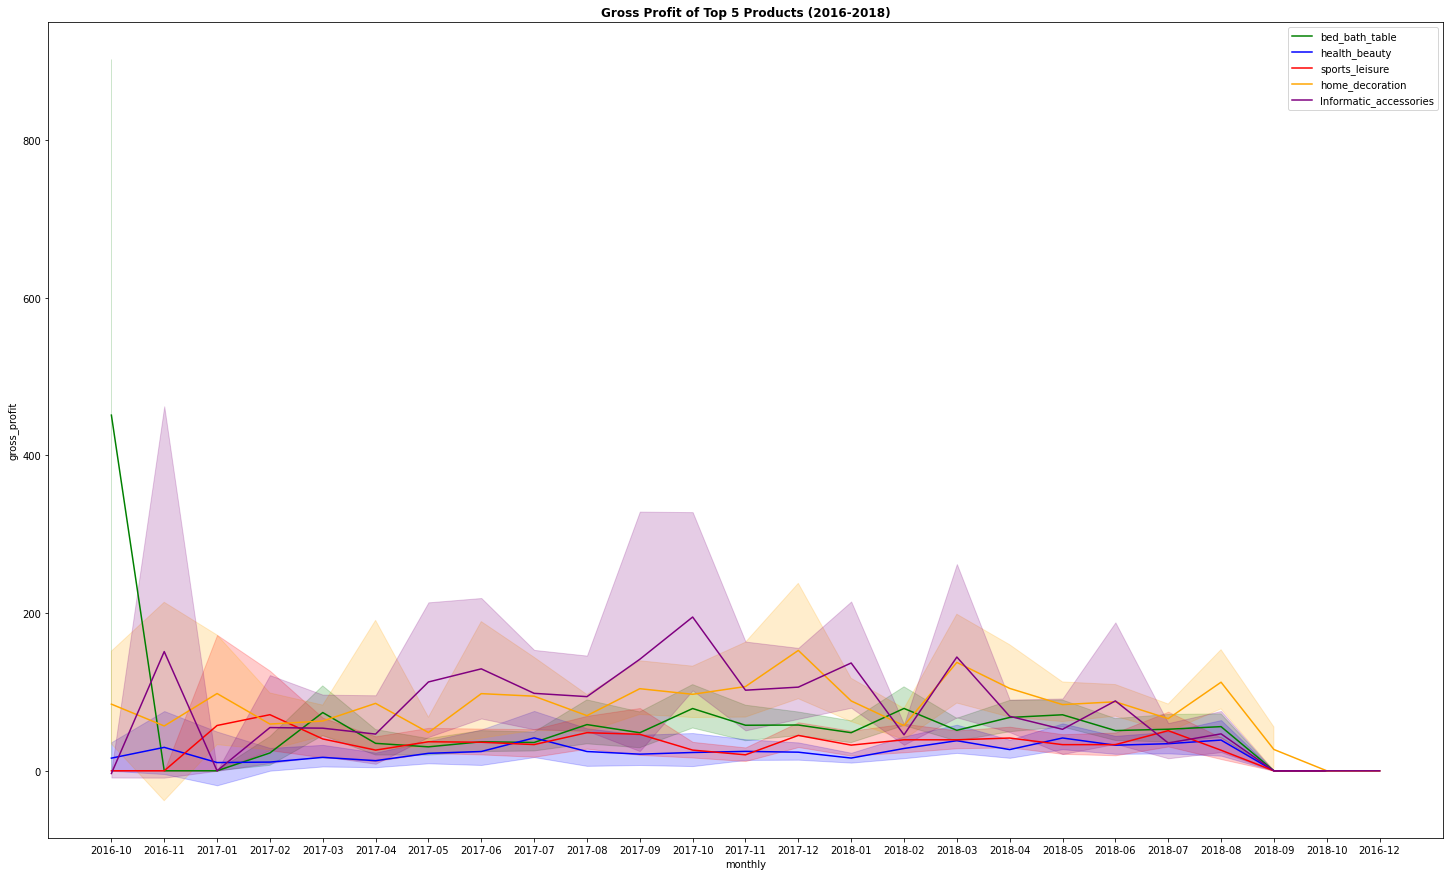

In [124]:
price_details = price_details.sort_values('monthly')

plt.figure(figsize=(25,15))

sns.lineplot(x='monthly',y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='bed_bath_table'], label='bed_bath_table',color="green")
sns.lineplot(x='monthly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='health_beauty'], label='health_beauty', color="blue")
sns.lineplot(x='monthly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='sports_leisure'], label='sports_leisure', color="red")
sns.lineplot(x='monthly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='furniture_decor'], label='home_decoration', color="orange")
sns.lineplot(x='monthly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='computers_accessories'], label='Informatic_accessories', color="purple")
plt.title("Gross Profit of Top 5 Products (2016-2018)",fontweight='bold')

- 주문 상품과 판매자의 상위 5개 상품 카테고리에 대한 연간 '총이익' 분포를 보여줌
- 2017년 8월부터 2017년 11월까지 informatic_accessories의 매출총이익이 가장 높음
- 반면에 bed_bath_table, beauty_health, sports_leisure의 상위 3개 제품 매출총이익은 200단위 미만

#### 한번에 여러제품 주문한 고객 데이터 확인

In [115]:
seller_products.groupby(['order_id'])['order_id'].count().sort_values(ascending=False).head(10)


order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
9bdc4d4c71aa1de4606060929dee888c    14
73c8ab38f07dc94389065f7eba4f297a    14
37ee401157a3a0b28c9c6d0ed8c3b24b    13
2c2a19b5703863c908512d135aa6accc    12
c05d6a79e55da72ca780ce90364abed9    12
Name: order_id, dtype: int64

In [118]:
seller_products[seller_products['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_id_shorten,seller_zip_code_prefix,seller_city,seller_state,seller_id_shorten
103540,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103541,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103542,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103543,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103544,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103545,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103546,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103547,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103548,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9
103549,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2017-07-31,2017-07-28,...,3.0,800.0,21.0,4.0,15.0,228f844c,3813,sao paulo,SP,5a56e9


## 데이터 정리

In [126]:
#reading datas
import time
start = time.time()
data = pd.read_csv("data/olist_customers_dataset.csv")
geo_data = pd.read_csv("data/olist_geolocation_dataset.csv")
order_itemdata = pd.read_csv("data/olist_order_items_dataset.csv")
pay_data = pd.read_csv("data/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("data/olist_order_reviews_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_prddata = pd.read_csv("data/olist_products_dataset.csv")
order_selldata = pd.read_csv("data/olist_sellers_dataset.csv")
end = time.time()
print("reading time: ",(end-start),"sec")

reading time:  4.539981126785278 sec


In [129]:
#checking number of columns , column_names and no_of_rows

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

,dataset,no_of_columns,columns_name,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,products,10,"product_id, product_category_name, product_category_name_port, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095


In [130]:
#checking dtypes
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Greys')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",3,"product_id, product_category_name, product_category_name_port",0
6,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0


In [131]:
#checking no of null values

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_category_name_port, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",10,3071,9,"product_category_name, product_category_name_port, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,


In [132]:
rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

### 데이터 세트 병합

In [147]:
df = pd.merge(orders,pay_data, on="order_id")
df = df.merge(data, on="customer_id")
df = df.merge(order_itemdata, on="order_id")
df = df.merge(order_prddata, on="product_id")
df = df.merge(rev_new, on="order_id")
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."


In [148]:
print("Number of rows after merging:",len(df))
print("Number of columns after merging:",len(df.columns))

Number of rows after merging: 117329
Number of columns after merging: 33


### 결측값 처리

In [149]:
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1235
order_delivered_customer_date     2471
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name             1720
product_category_name_port        1695
product_name_lenght               1695
product_description_lengh

- order_approved_at의 null 값은 order_purchase_timestamp로 대체
- order_delivered_customer_date의 null 값은 order_estimated_delivery_date로 대체
- order_delivered_carrier_date 열을 삭제

In [150]:
#Handling missing values
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [151]:
#checking the replaced values
df.order_estimated_delivery_date[index[0]]

'2018-03-14 00:00:00'

In [152]:
# Handling missing values of numerical features
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [153]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('no_review',inplace=True)

Percentage of null reviews : 57.65837942878572 %


### 데이터 중복 제거

In [154]:
df.shape

(117329, 32)

In [155]:
dup_rows = df[df.duplicated(['order_id','product_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
31,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-28 18:58:22,2018-09-10 00:00:00,1,credit_card,2,279.30,958ac7760e5484df1496ba5833ab6117,89117,gaspar,SC,2,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.90,22.75,perfumery,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,5,"entrega no prazo, amei"
33,78037c5f4d9f1f7bab0207f22c4e92f1,ec8f2dcb080511771e52af7ca42117f5,delivered,2018-01-02 17:56:52,2018-01-02 18:10:14,2018-01-16 17:12:37,2018-01-31 00:00:00,1,credit_card,2,261.46,60a1e88691ef46c62b52fb2b994d7675,25850,paraiba do sul,RJ,2,595fac2a385ac33a80bd5114aec74eb8,ef0ace09169ac090589d85746e3e036f,2018-01-08 18:10:14,117.90,12.83,perfumery,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,2,no_review
41,9883744c6400cfad8a620ddb82b9793c,df7f0c302322f4a233a07fb9cbddb46c,delivered,2018-05-02 10:19:23,2018-05-02 10:34:27,2018-05-08 21:06:05,2018-05-24 00:00:00,1,credit_card,2,271.24,7dd163b8e3d4e09daa9e16091dd6dd26,4002,sao paulo,SP,2,595fac2a385ac33a80bd5114aec74eb8,ef0ace09169ac090589d85746e3e036f,2018-05-08 10:31:25,119.90,15.72,perfumery,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,5,Fui muito bem atendida
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117307,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,delivered,2018-05-07 09:01:58,2018-05-08 04:34:10,2018-05-14 18:52:56,2018-05-30 00:00:00,1,boleto,1,856.16,62b8761192c86f4ead06f4a433096a2b,88370,navegantes,SC,4,f5e585e188891ed071253bacfad60820,30829ded4523ab9224b93bc49a62c95f,2018-05-14 04:32:04,194.80,19.24,computers_accessories,informatica_acessorios,38.0,511.0,1.0,100.0,16.0,8.0,12.0,5,Adquiri 4 cartuchos 41 Canon e recebi somente ...
117312,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,delivered,2017-11-18 12:51:32,2017-11-18 13:06:23,2017-11-27 14:55:45,2017-12-04 00:00:00,1,credit_card,1,341.00,dc9ccd8be2d922f8583d97933b06c5f4,13087,campinas,SP,2,af16005fca813272caf59c432153949e,82e0a475a88cc9595229d8029273f045,2017-11-24 13:06:23,75.90,9.35,furniture_decor,moveis_decoracao,55.0,1186.0,2.0,800.0,53.0,8.0,20.0,1,"COMPREI 04, MAS SO RECEBI 02"
117313,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,delivered,2017-11-18 12:51:32,2017-11-18 13:06:23,2017-11-27 14:55:45,2017-12-04 00:00:00,1,credit_card,1,341.00,dc9ccd8be2d922f8583d97933b06c5f4,13087,campinas,SP,3,af16005fca8132

In [156]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','product_id','customer_id','order_purchase_timestamp','order_delivered_customer_date', 'customer_unique_id','review_comment_message'}, keep='first', inplace=False)
df= df.reindex()
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,"Só achei ela pequena pra seis xícaras ,mais é ..."
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3,no_review
6,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,4,Muito bom o produto.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117323,87b4c933f31145a28413b39d880ad6c3,ddfdf5e9b2659e1fbd073404c9b762e0,delivered,2018-03-02 17:12:05,2018-03-02 17:49:24,2018-03-16 17:21:55,2018-03-21 00:00:00,1,credit_card,1,85.25,490c3c53ca927221bccbb00706afbcf9,2042,sao paulo,SP,1,cbaf5898b92064cd5e399c7cff291d0a,06a2c3af7b3aee5d69171b0e14f0ee87,2018-03-08 17:31:06,57.99,27.26,health_beauty,beleza_saude,50.0,1031.0,1.0,350.0,19.0,12.0,13.0,5,Satisfação garantida
117324,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-23 15:36:29,2017-08-31 00:00:00,1,credit_card,10,748.24,fb9310710003399b031add3e55f34719,3318,sao paulo,SP,1,0df37da38a30a713453b03053d60d3f7,218d46b86c1881d022bce9c68a7d4b15,2017-08-17 21:35:26,356.00,18.12,sports_leisure,esporte_lazer,53.0,1105.0,1.0,2800.0,28.0,23.0,23.0,4,no_review
117326,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2018-01-26 15:45:14,2018-01-18 00:00:00,1,credit_card,1,71.04,a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR,1,3d2c44374ee42b3003a470f3e937a2ea,

In [157]:
print("Number of rows after dedublication:",len(df))
print("Number of columns after deduplication:",len(df.columns))

Number of rows after dedublication: 101878
Number of columns after deduplication: 32


## 데이터 분석

In [158]:
# all time stamps are in object dtype as observed above converting it into datetime 
df[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']]=df[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [159]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_customer_date       0
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1476
product_category_name_port       1454
product_name_lenght              1454
product_description_lenght       1454
product_photos_qty               1454
product_weig

In [160]:
df.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
count,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,100424.000000,100424.000000,100424.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000
mean,1.023185,2.959010,161.433317,35114.638116,1.046153,124.206951,20.105371,48.877689,786.803543,2.239246,2088.402962,30.077828,16.398251,23.037103,4.075463
std,0.255513,2.746049,219.436793,29814.808990,0.276434,187.508494,15.871753,9.994362,650.346334,1.743548,3749.106887,16.086148,13.304270,11.744047,1.354606
min,1.000000,0.000000,0.010000,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000
25%,1.000000,1.000000,61.290000,11320.000000,1.000000,40.000000,13.140000,43.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000
50%,1.000000,2.000000,105.810000,24360.000000,1.000000,78.720000,16.320000,52.000000,602.000000,2.000000,700.000000,25.000000,13.000000,20.000000,5.000000
75%,1.000000,4.000000,179.800000,58900.000000,1.000000,139.000000,21.200000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,5.000000
max,27.000000,24.000000,13664.080000,99990.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000


### review_score 분류

In [161]:
# checking the target variables i.e review score 
df.review_score.value_counts()

5    58583
4    19538
1    11883
3     8502
2     3372
Name: review_score, dtype: int64

In [162]:
def partition(x):
    if x < 3:
        return 0
    elif x == 3:
        return 1
    else :
        return 2
df['review_score']=df['review_score'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
df.review_score.value_counts()

2    78121
0    15255
1     8502
Name: review_score, dtype: int64

Total Positive Reviews : 78121 , ( 328.8336069369028 %)
Total Neutral Reviews : 8502 , ( 35.787346887233234 %)
Total Negative Reviews : 15255 , ( 64.21265311276676 %)




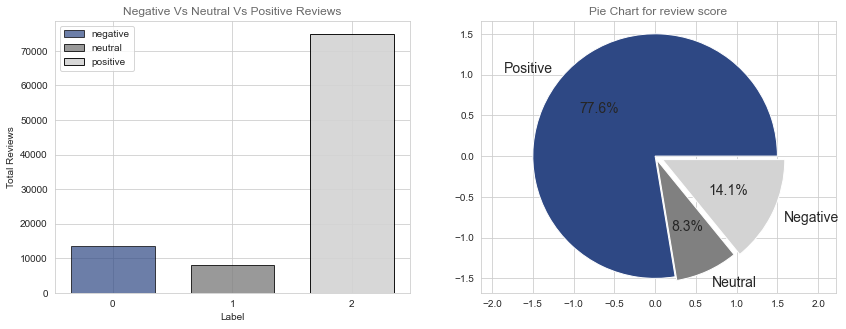

In [163]:
#counting the review score with 1 and 0
y_value_counts = df.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[2], ", (", (y_value_counts[2]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Neutral Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Neutral Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.10,10.20],['0','1','2'])
#creating bar plots
plt.bar(10,13621, color = '#2e4884', width = 0.07, alpha=0.7, label='negative', edgecolor='black')
plt.bar(10.10,7978, color = 'gray', width = 0.07, alpha=0.8, label='neutral', edgecolor='black')
plt.bar(10.20,74917, color = 'lightgray', width = 0.07, alpha=0.9, label='positive', edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
# 각 영역의 비율과 이름을 ratio와 labels로 지정
ratio = [74917,7978,13621]
labels = ['Positive','Neutral', 'Negative']
# explode는 부채꼴이 파이 차트의 중심에서 벗어나는 정도를 설정
explode = (0, 0.05, 0.1)
# colors를 사용하면 각 영역의 색상을 자유롭게 지정
color={'#2e4884','lightgray','gray'}
# # wedgeprops는 부채꼴 영역의 스타일을 설정
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
# autopct는 부채꼴 안에 표시될 숫자의 형식을 지정 -> 소수점 한자리까지 표시하도록 설정
# startangle는 부채꼴이 그려지는 시작 각도를 설정 : 디폴트는 0도 (양의 방향 x축)
# counterclock=False로 설정하면 시계 방향 순서로 부채꼴 영역이 표시
# shadow를 True로 설정하면, 파이 차트에 그림자가 표시
plt.pie(ratio,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()

In [164]:
#Correlation matrix 
corr_matrix = df.corr()

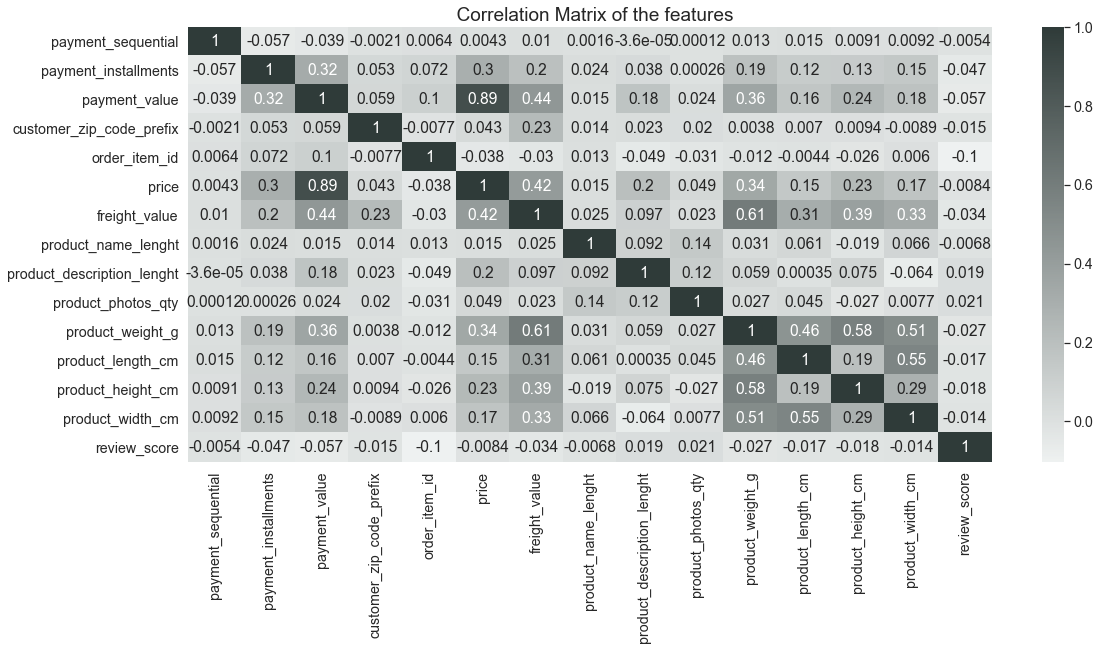

In [165]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.3)
cmap = sns.light_palette("#2f3b39",as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap,annot=True)
plt.title("  Correlation Matrix of the features",fontsize=19)
plt.savefig('plot16.png', dpi=300, bbox_inches='tight')
plt.show()

In [166]:
#finding corr- values of the features with review_score
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.020685
product_description_lenght    0.018756
payment_sequential           -0.005381
product_name_lenght          -0.006785
price                        -0.008417
product_width_cm             -0.014278
customer_zip_code_prefix     -0.015221
product_length_cm            -0.016844
product_height_cm            -0.018242
product_weight_g             -0.026949
freight_value                -0.033832
payment_installments         -0.047267
payment_value                -0.057074
order_item_id                -0.102381
Name: review_score, dtype: float64

In [167]:
#checking unique ids
print("Total number of unique seller_id:",len((df.seller_id).unique()))
print("Total number of unique product_id:",len((df.product_id).unique()))
print("Total number of unique customer_id:",len((df.customer_unique_id).unique()))

Total number of unique seller_id: 3090
Total number of unique product_id: 32789
Total number of unique customer_id: 94720


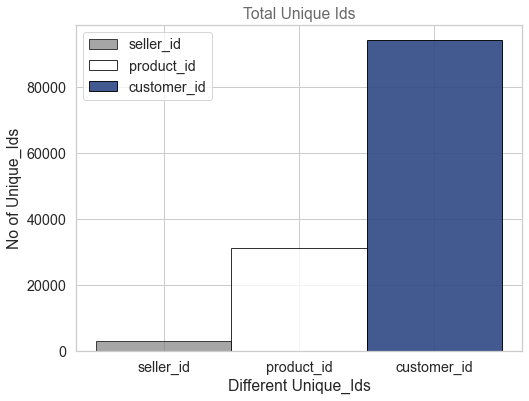

In [168]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.ylabel('No of Unique_Ids')
plt.xlabel('Different Unique_Ids')
plt.title('Total Unique Ids',color='dimgrey')
plt.xticks([10,10.25,10.50],['seller_id','product_id','customer_id'])
#creating bar plots
plt.bar(10,3022, color = 'grey', width = 0.25,alpha=0.7,label='seller_id',edgecolor='black')
plt.bar(10.25,31053, color = 'white', width = 0.25,alpha=0.8,label='product_id',edgecolor='black')
plt.bar(10.50,94087, color = '#2e4884', width = 0.25,alpha=0.9,label='customer_id',edgecolor='black')
plt.legend()
plt.show()

### payment유형

In [169]:
df.groupby('payment_type').size()

payment_type
boleto         20190
credit_card    77382
debit_card      1580
voucher         2726
dtype: int64

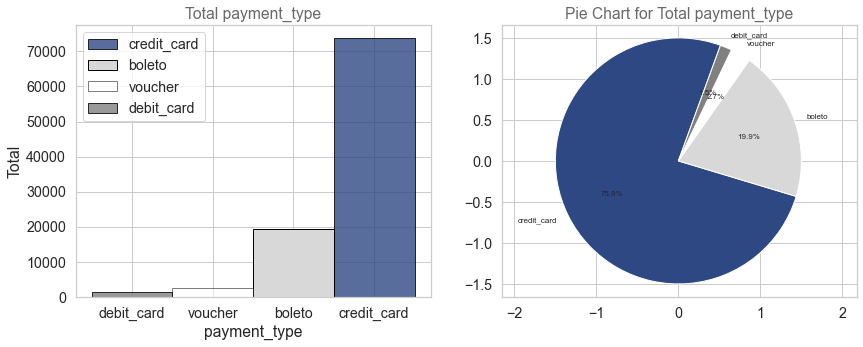

In [171]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total')
plt.xlabel('payment_type')
plt.title('Total payment_type',color='dimgrey')
plt.xticks([10,10.25,10.50,10.75],['debit_card','voucher','boleto','credit_card'])
#creating bar plots
plt.bar(10.75,73816, color = '#2e4884', width = 0.25,alpha=0.8,label='credit_card',edgecolor='black')
plt.bar(10.50,19345, color = '#d8d8d8', width = 0.25,label='boleto',edgecolor='black')
plt.bar(10.25,2604, color = 'white', width = 0.25,alpha=0.5,label='voucher',edgecolor='black')
plt.bar(10,1490, color = 'grey', width = 0.25,alpha=0.8,label='debit_card',edgecolor='black')

plt.legend()

plt.subplot(1,2,2)
s= [ 73816,19345, 2604,1490]
new = ['credit_card','boleto','voucher','debit_card']

explode = (0, 0, 0,0)  
colours = {'credit_card': '#2e4884',
           'boleto': '#d8d8d8',
           'voucher': 'w',
           'debit_card': 'grey'}

color ={'#2e4884','grey','#d8d8d8','w'}

plt.pie(s, explode=explode, labels=new,colors=[colours[key] for key in new] , autopct='%1.1f%%',shadow=False, startangle=70,radius=1.5,frame=True,textprops={'fontsize': 8})
plt.axis('equal') 
plt.title('Pie Chart for Total payment_type',color='dimgrey')
plt.show()

* Baleto ==> Boleto Bancário, 간단히 Boleto(영어: 티켓)라고 하는 것은 FEBRABAN에서 규제하는 브라질의 지불 방법으로, Brazil Federation of Banks 의 약자. ATM, 지점 시설 및 인터넷 뱅킹에서 지불할 수 있음. 은행, 우체국, 복권 대리점 및 일부 슈퍼마켓은 마감일까지.

- 대부분의 주문이 신용 카드를 사용하여 지불되고 두 번째로 많이 사용되는 지불 방법은 boleto

- 신용카드를 75.9%, baleto를 19.9%, 바우처와 체크카드는 4.2%를 사용.

In [172]:
temp = pd.DataFrame(df.groupby('payment_type')['review_score'].agg(lambda x: x.eq(2).sum())).reset_index()

# Pandas dataframe grouby count
temp['total'] = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp['Avg']   = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
#sorting dataframe
temp = temp.sort_values(by=['total'], ascending=True)

In [173]:
#Simplifing the plots using pareto plots
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.bar(x, y,color='#2e4884',edgecolor='black',alpha=0.9)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5,color='black')
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]),fontsize=15)    
    
    if title:
        plt.title(title,color='dimgrey',fontsize=15)
    
    plt.tight_layout()
    plt.show()

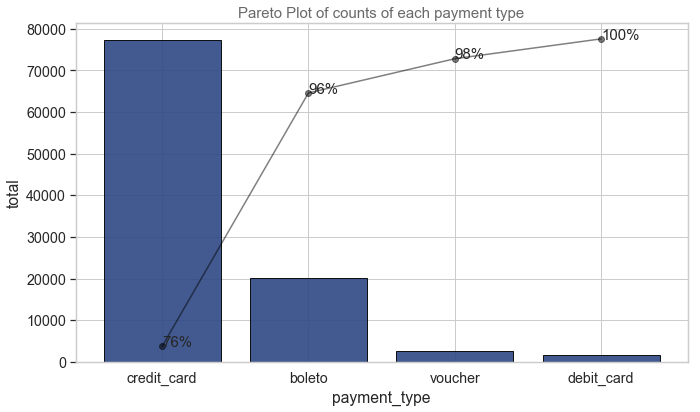

In [174]:
pareto_plot(temp,x='payment_type',y='total',title="Pareto Plot of counts of each payment type")

#### payment & review

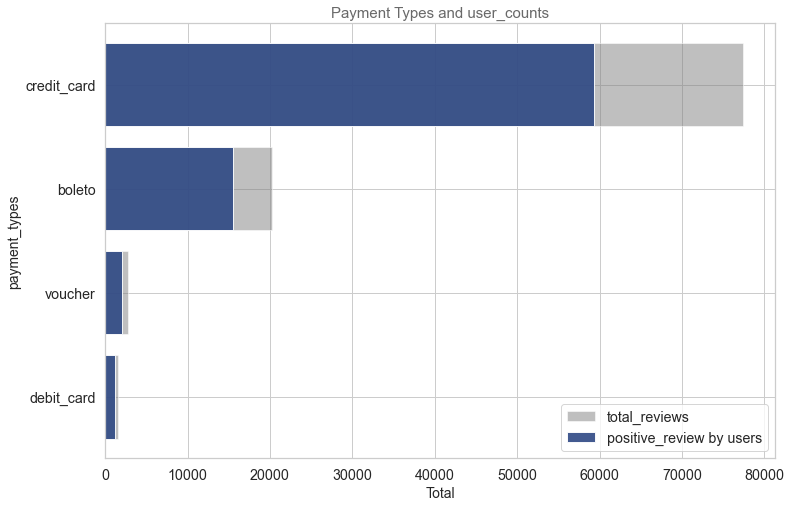

In [175]:
#Let us see how this categorical feature related with our target variable
plt.figure(figsize=(12,8))
p1=plt.barh(temp.payment_type,temp.total,color='grey',alpha=0.5)
p2=plt.barh(temp.payment_type,temp.review_score,color='#2e4884',alpha=0.9)
plt.title('Payment Types and user_counts',fontsize=15,color='dimgrey')
plt.ylabel('payment_types',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review by users'))

plt.show()

### 일변량 분석: State wise 기반 고객 수

![alt text](https://st4.depositphotos.com/1374738/23094/v/950/depositphotos_230940566-stock-illustration-map-brazil-divisions-states.jpg)

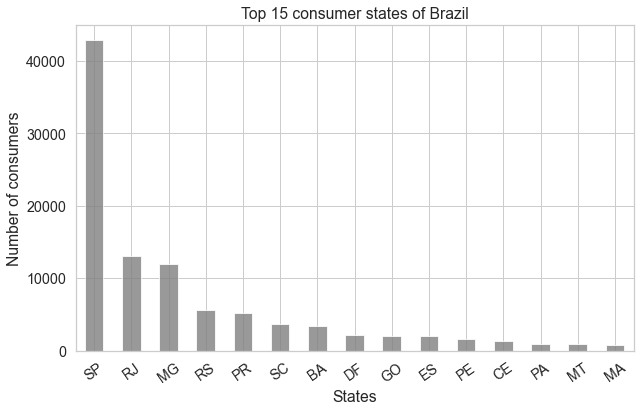

In [176]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.customer_state.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer states of Brazil")
ax.set_xlabel("States")
plt.xticks(rotation=35)
ax.set_ylabel("Number of consumers")
plt.show()

- 총 소비자의 42%는 SP(상파울루), 12.9%는 RJ(리우데자네이루), 11.7%는  MG(Minas Gerais) 출신으로 대부분의 소비자가 이 주 출신

#### state & review

In [177]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2, col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values,color = 'grey',alpha=0.5)
    p2 = plt.bar(ind, data[col2].values,color= '#2e4884',alpha=0.8)

    plt.ylabel('Reviews')
    plt.title('% of review_score  ')
    plt.xticks(ind-0.1, list(data[xtick].values), rotation=0)
    plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review'))
    plt.show()

In [178]:
# Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
temp_1 = pd.DataFrame(df.groupby('customer_state')['review_score'].agg(lambda x: x.eq(2).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


temp_1['total'] = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_1['Avg']   = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_1= temp_1.rename(columns={'review_score':'positive_review'})
temp_1= temp_1.sort_values(by=['total'], ascending=False)

In [179]:
temp_1

,customer_state,positive_review,total,Avg
25,SP,33939,42872,1.663720
18,RJ,9256,13113,1.495005
10,MG,9313,11936,1.645191
22,RS,4373,5629,1.636170
17,PR,4094,5141,1.669325
23,SC,2824,3712,1.612069
4,BA,2432,3444,1.515099
6,DF,1687,2205,1.609977
8,GO,1572,2087,1.600862
7,ES,1563,2072,1.598938


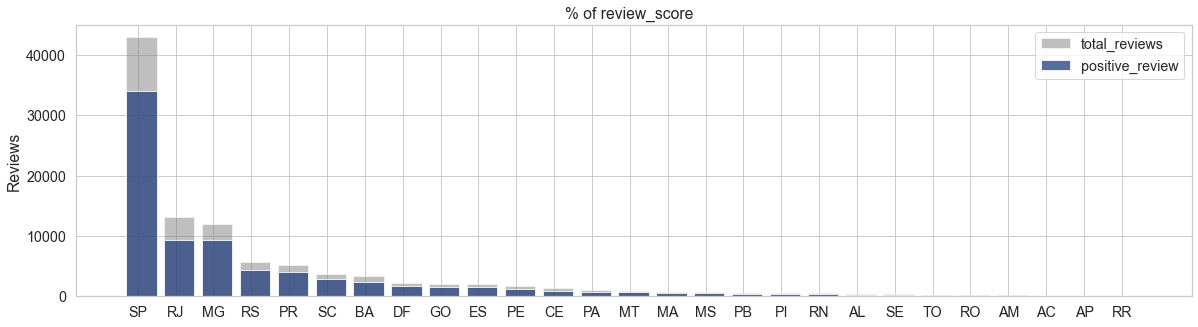

In [180]:
stack_plot(temp_1,'customer_state',col2='positive_review', col3='total')

- 주별 리뷰의 위 스택 플롯에서 각 주의 소비자 대부분이 긍정적인 리뷰 를 제공했다는 결론
- SP 주 에서는 총 40800개의 리뷰에서 35791개의 리뷰가 긍정적인 리뷰이고 RJ 주의 경우 총 12569리뷰에서 9968개의 리뷰가 긍정적
- consumer_state가 문제에 대한 중요한 기능이 될 수 있음

### 일변량 분석: category

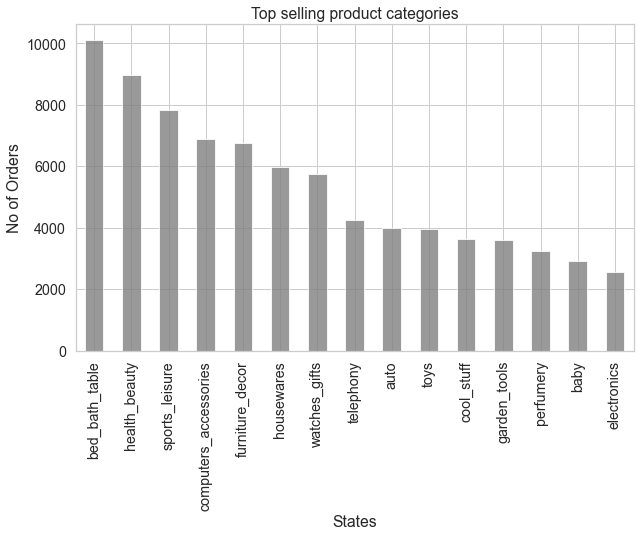

In [181]:
# State with the product_category count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.product_category_name.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("States")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

In [184]:
df.groupby(["product_category_name"])["product_id"].count().sort_values(ascending=False).head(10)

product_category_name
bed_bath_table           10104
health_beauty             8974
sports_leisure            7822
computers_accessories     6875
furniture_decor           6752
housewares                5983
watches_gifts             5753
telephony                 4256
auto                      3974
toys                      3950
Name: product_id, dtype: int64

#### category & review

In [185]:
temp_2 = pd.DataFrame(df.groupby('product_category_name')['review_score'].agg(lambda x: x.eq(2).sum())).reset_index()

# Pandas dataframe grouby count
temp_2['total'] = list(pd.DataFrame(df.groupby('product_category_name')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_2['Avg']   = list(pd.DataFrame(df.groupby('product_category_name')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_2 = temp_2.sort_values(by=['total'], ascending=True)
temp_2

,product_category_name,review_score,total,Avg
61,security_and_services,1,2,1.000000
29,fashion_childrens_clothes,7,8,1.750000
52,la_cuisine,10,12,1.666667
11,cds_dvds_musicals,11,12,1.916667
46,home_comfort_2,16,23,1.478261
...,...,...,...,...
39,furniture_decor,4972,6752,1.561019
15,computers_accessories,5148,6875,1.579782
65,sports_leisure,6196,7822,1.658016
43,health_beauty,7114,8974,1.664364


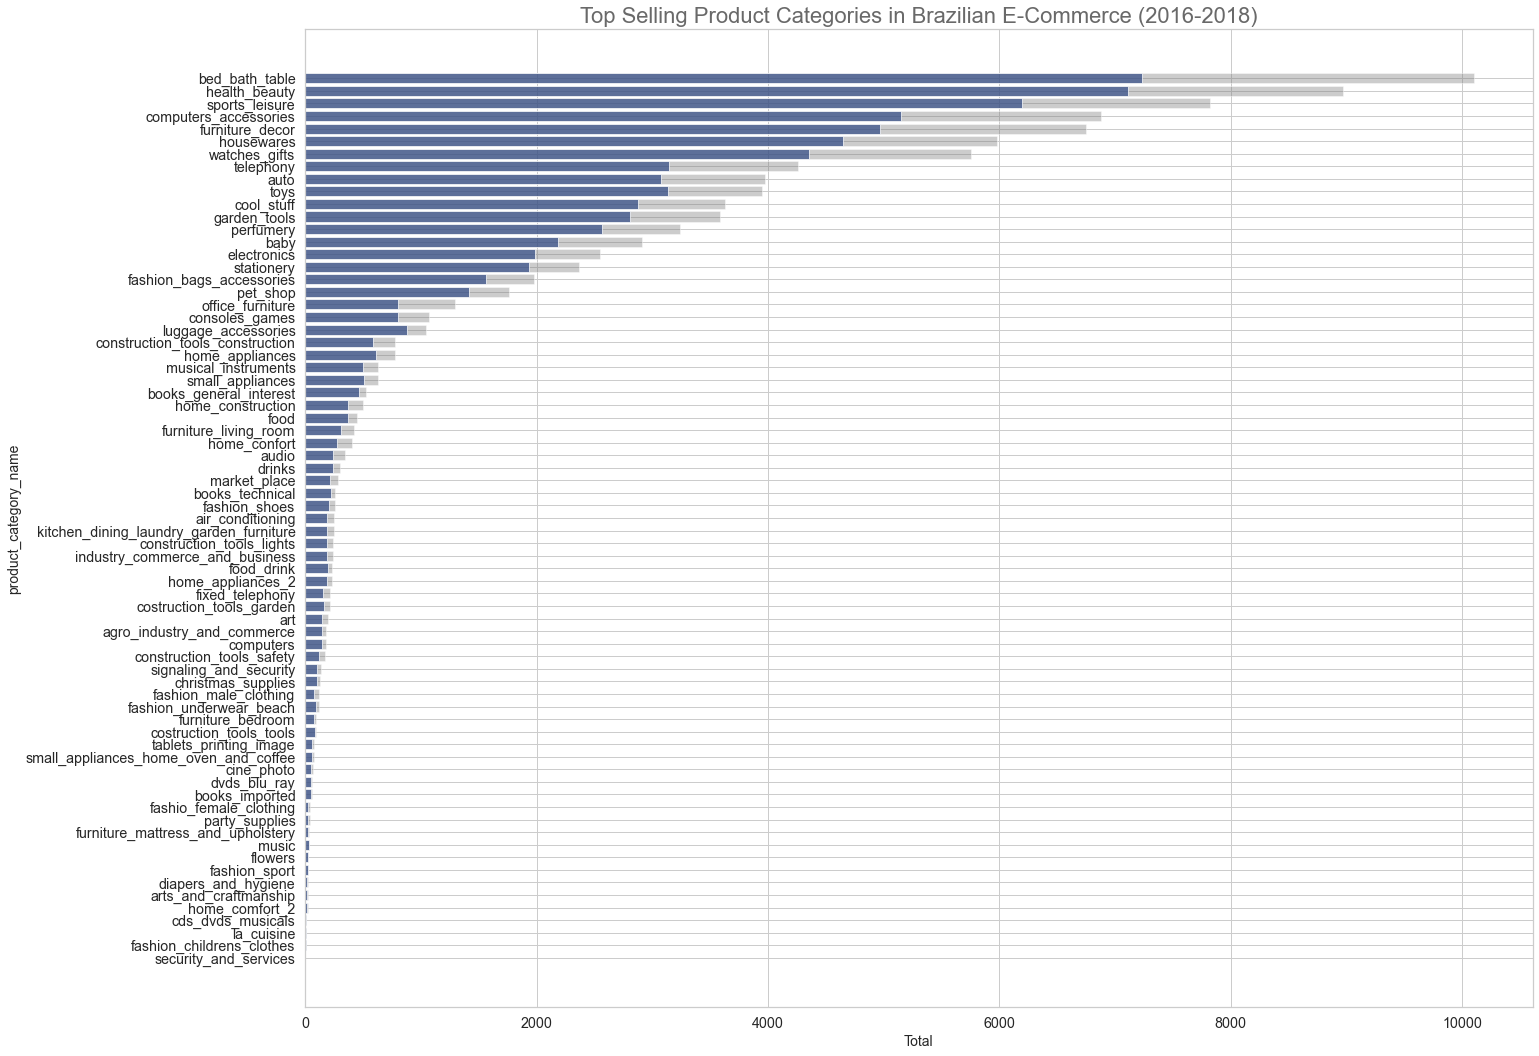

In [186]:
plt.figure(figsize=(22,18))
plt.barh(temp_2.product_category_name,temp_2.total,color='grey',alpha=0.4)
plt.barh(temp_2.product_category_name,temp_2.review_score,color='#2e4884',alpha=0.7)
plt.title('Top Selling Product Categories in Brazilian E-Commerce (2016-2018)',fontsize=22,color='dimgrey')
plt.ylabel('product_category_name',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.savefig('plot14.png', dpi=480, bbox_inches='tight')
plt.show()

- 총 리뷰와 긍정적인 의미의 리뷰를 보여주는 스택 플롯
- bed_bath_table 카테고리에 대한 대부분의 리뷰가 긍정적이고 다른 제품 범주에 대해서도 동일하다는 결론

### 일변량 분석: frequency of orders Vs Number of Consumers

Text(0.5, 1.0, 'Number of orders per customer')

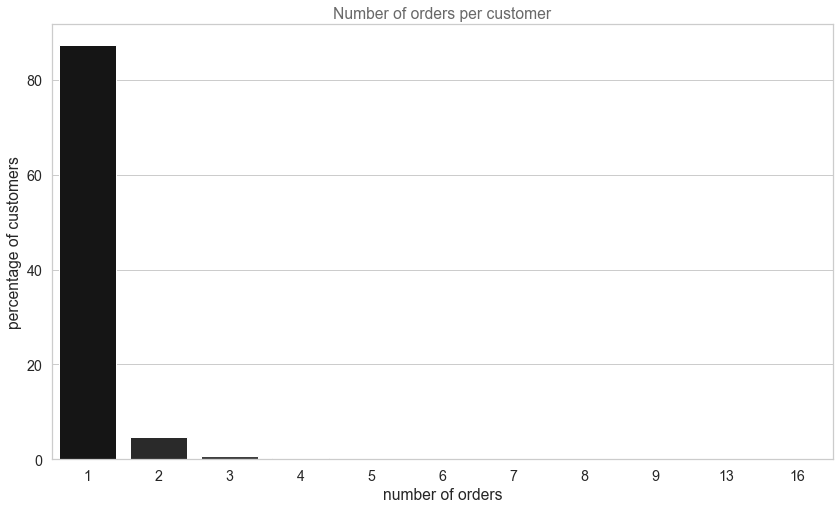

In [189]:
# plotting frequency orders vs  the number of consumers 
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
#소비자를 세어 백분율로 환산하여 분포를 제대로 시각화
num_orders=df['customer_unique_id'].value_counts().value_counts()/df.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='percentage of customers',palette='gray')
# plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

Text(0.5, 1.0, 'Number of orders per customer')

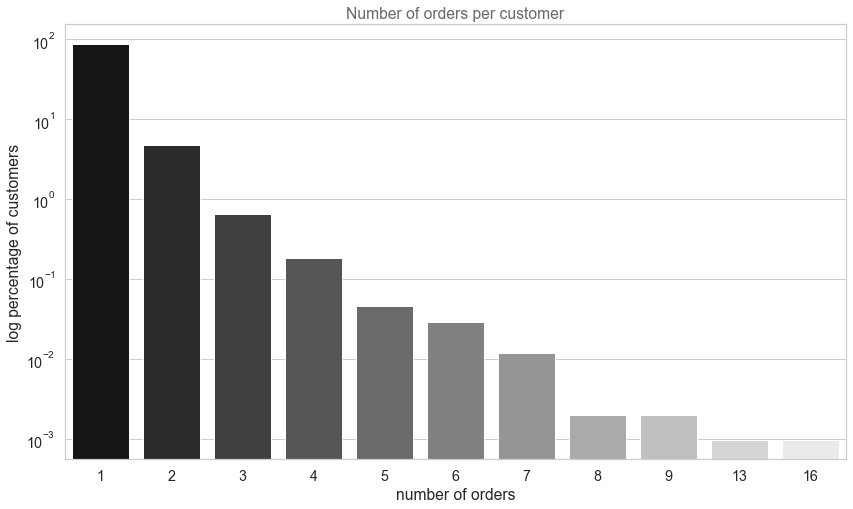

In [190]:
# plotting frequency orders vs  the number of consumers 
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
#소비자를 세어 백분율로 환산하여 분포를 제대로 시각화
num_orders=df['customer_unique_id'].value_counts().value_counts()/df.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='gray')
plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

### 일변량 분석: Order_status

[viz_utils | Kaggle](https://www.kaggle.com/thiagopanini/viz-utils/data)

In [191]:
# matplotlib 축 형식 지정
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors

    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

In [192]:
def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
    Parâmetros
    ----------
    classifiers: conjunto de classificadores em forma de dicionário [dict]
    X: array com os dados a serem utilizados no treinamento [np.array]
    y: array com o vetor target do modelo [np.array]

    Retorno
    -------
    None
    """

    # Verificando plotagem por quebra de alguma variável categórica
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Verificando a plotagem de top categorias
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    # Validando demais argumentos e plotando gráfico
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatando eixos
    format_spines(ax, right_border=False)

    # Inserindo rótulo de percentual
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


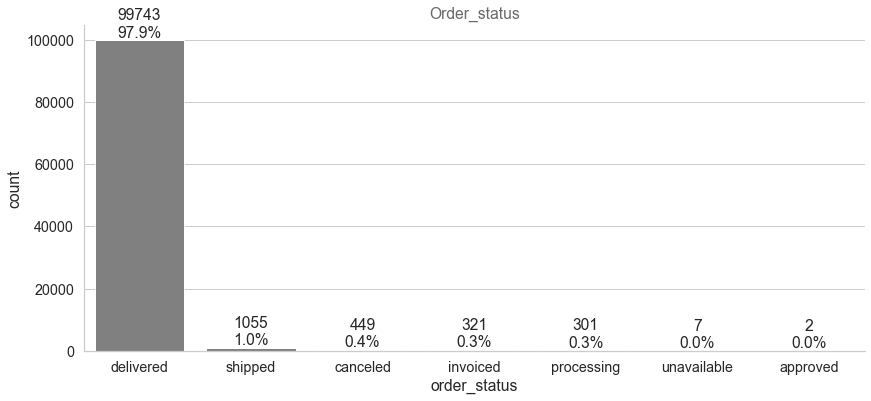

In [193]:
#by using custom countplots in (viz_utils)
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df, x='order_status', ax=ax,palette=['grey'])
# sns.barplot(data=df, x='order_status', ax=ax,palette='grey')
plt.title('Order_status',color='dimgrey')
plt.show()

### 월별 주문량 변화

In [194]:
#calulating number of days for the data is taken
print(df.order_approved_at.max() - df.order_approved_at.min(), ' from ', 
      df.order_approved_at.min(), ' to ', df.order_approved_at.max())

699 days 07:56:34  from  2016-10-04 09:43:32  to  2018-09-03 17:40:06


In [195]:
df_1=df
# Extracting attributes for purchase date - Year and Month
df_1['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year) #gives year Example :2016-10-04 09:43:32 ---->2016
df_1['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month) #gives month Example :2016-10-04 09:43:32 ---->10
df_1['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))#gives month in short form Example :2016-10-04 09:43:32 ---->10--> Oct
df_1['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))#gives month&year Example :2016-10-04 09:43:32 ---->201610
df_1['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))#gives month,yr and date  Example :2016-10-04 09:43:32 ---->20161004
df_1['order_purchase_month_yr'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime("%b-%y"))

# Extracting attributes for purchase date - Day and Day of Week
df_1['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df_1['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_1['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_1['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_1['order_purchase_time_day'] = pd.cut(df_1['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_month_yr,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,"Não testei o produto ainda, mas ele veio corre...",2017,10,Oct,201710,20171002,Oct-17,2,0,Mon,10,Morning
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,Deveriam embalar melhor o produto. A caixa vei...,2017,8,Aug,201708,20170815,Aug-17,15,1,Tue,18,Afternoon
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,"Só achei ela pequena pra seis xícaras ,mais é ...",2017,8,Aug,201708,20170802,Aug-17,2,2,Wed,18,Afternoon
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,housewares,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,1,no_review,2017,10,Oct,201710,20171023,Oct-17,23,0,Mon,23,Night
6,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,2,Muito bom o produto.,2018,7,Jul,201807,20180724,Jul-18,24,1,Tue,20,Night


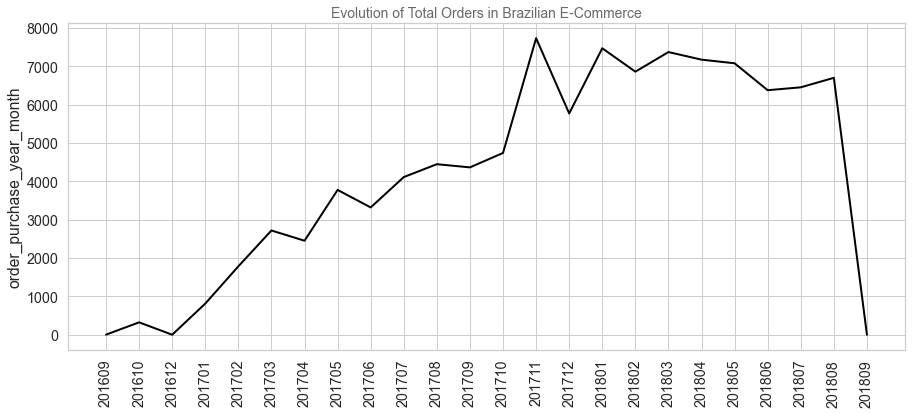

In [196]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df_1['order_purchase_year_month'].value_counts().sort_index(), 
             color='black', linewidth=2)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')
plt.xticks(rotation=90)
plt.show()